In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


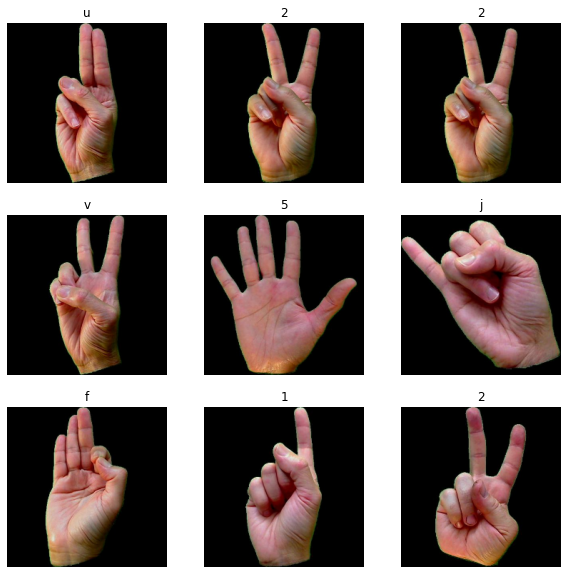

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation


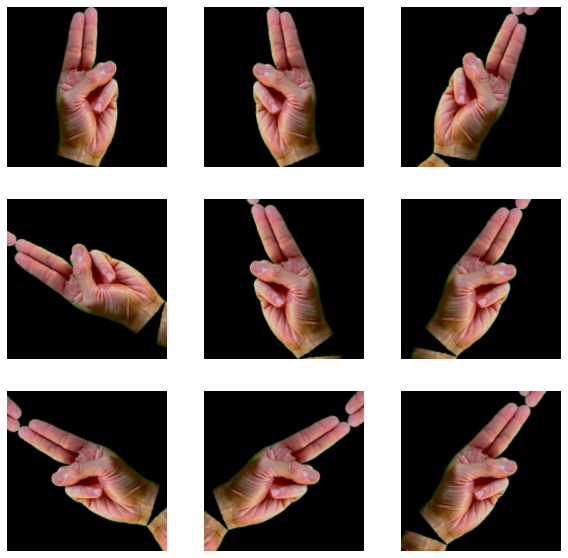

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet',classes= 1000, classifier_activation='softmax')

102981632/102967424 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [11]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n03494278', 'harmonica', 0.33963177),
  ('n04074963', 'remote_control', 0.04029469)],
 [('n02786058', 'Band_Aid', 0.14098129), ('n03804744', 'nail', 0.09073848)],
 [('n03793489', 'mouse', 0.12421638), ('n02317335', 'starfish', 0.088265665)],
 [('n02786058', 'Band_Aid', 0.2581139), ('n03804744', 'nail', 0.027536714)],
 [('n02786058', 'Band_Aid', 0.13102125), ('n03804744', 'nail', 0.048030544)],
 [('n02786058', 'Band_Aid', 0.07572001), ('n01990800', 'isopod', 0.07262693)],
 [('n02786058', 'Band_Aid', 0.30137065), ('n02667093', 'abaya', 0.071002066)],
 [('n02786058', 'Band_Aid', 0.5407092), ('n03804744', 'nail', 0.052885175)],
 [('n02786058', 'Band_Aid', 0.15612388),
  ('n03250847', 'drumstick', 0.08840165)],
 [('n02786058', 'Band_Aid', 0.5016715), ('n03804744', 'nail', 0.1289279)],
 [('n02786058', 'Band_Aid', 0.560392), ('n03804744', 'nail', 0.12798499)],
 [('n02786058', 'Band_Aid', 0.14278662), ('n03804744', 'nail', 0.06348566)],
 [('n02786058', 'Band_Aid', 0.2872213), ('n03871628',

In [12]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet', classes=26, classifier_activation='softmax') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False) 
  x = tfl.GlobalAveragePooling2D()(x)

  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model


In [13]:
model = asl_model(IMG_SIZE, data_augmentation)

94781440/94765736 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [15]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
initial_epochs = 50
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 699s 13s/step - loss: 2.9395 - accuracy: 0.2232 - val_loss: 2.2763 - val_accuracy: 0.3541
Epoch 2/50
56/56 [==============================] - 10s 164ms/step - loss: 1.8363 - accuracy: 0.5122 - val_loss: 1.7848 - val_accuracy: 0.5292
Epoch 3/50
56/56 [==============================] - 10s 174ms/step - loss: 1.3962 - accuracy: 0.6451 - val_loss: 1.4534 - val_accuracy: 0.6233
Epoch 4/50
56/56 [==============================] - 10s 165ms/step - loss: 1.1457 - accuracy: 0.7076 - val_loss: 1.2871 - val_accuracy: 0.6671
Epoch 5/50
56/56 [==============================] - 10s 167ms/step - loss: 0.9667 - accuracy: 0.7643 - val_loss: 1.1205 - val_accuracy: 0.7162
Epoch 6/50
56/56 [==============================] - 10s 167ms/step - loss: 0.8709 - accuracy: 0.7814 - val_loss: 1.0288 - val_accuracy: 0.7268
Epoch 7/50
56/56 [==============================] - 10s 165ms/step - loss: 0.7613 - accuracy: 0.8126 - val_loss: 0.9723 - val_accuracy: 0.7175


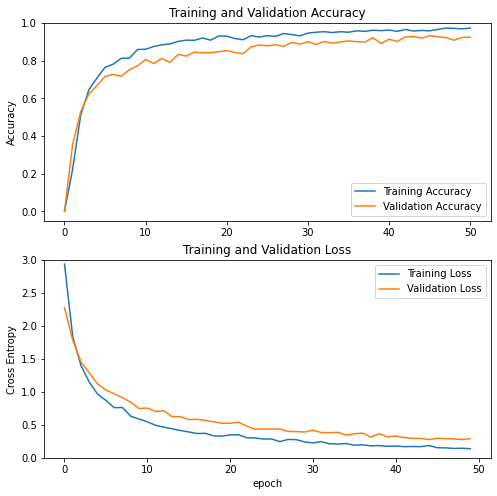

In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

Highest Accuracy: 97.27427363395691%
Highest Validation Accuracy: 93.23607683181763%
